In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

In [2]:
SOURCE_DIR="/kaggle/input/combined-dataset-alzhimer-tumor-zip/combined_dataset_alzhimer _tumor"
DEST_DIR="/kaggle/working/"
output_dir=os.path.join(DEST_DIR,"merged_dataset")

In [3]:
alz_classes=["MildDemented", "ModerateDemented","NonDemented","VeryMildDemented"]
tumor_classes=["glioma", "meningioma", "notumor","pituitary"]
all_classes=["Alzhimer_"+c for c in alz_classes]+["Tumor_" +c for c in tumor_classes]

In [4]:
def gather_images(base, disease, subtype):
    imgs=[]
    for split in ["Training","Validation","Testing"]:
        folder=os.path.join(base, disease, split, subtype)
        if os.path.exists(folder):
            for f in os.listdir(folder):
                imgs.append(os.path.join(folder, f))
    return imgs

In [5]:
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir, exist_ok=True)

In [6]:
splits={"train":[],"val":[],"test":[]}

In [7]:
for subtype in alz_classes:
    images=gather_images(SOURCE_DIR, "Alzhimer", subtype)
    random.shuffle(images)
    n=len(images)
    n_train=int(n*0.75)
    n_test=int(n*0.15)
    n_val=n-n_train-n_test
    splits["train"].extend([(p,f"Alzhimer_{subtype}") for p in images[:n_train]])
    splits["test"].extend([(p,f"Alzhimer_{subtype}") for p in images[n_train:n_train+n_test]])
    splits["val"].extend([(p,f"Alzhimer_{subtype}") for p in images[n_train+n_test:]])

In [8]:
for subtype in tumor_classes:
    images = gather_images(SOURCE_DIR, "Tumor", subtype)
    random.shuffle(images)
    n = len(images)
    n_train = int(n * 0.75)
    n_test = int(n * 0.15)
    n_val = n - n_train - n_test
    splits["train"].extend([(p, f"Tumor_{subtype}") for p in images[:n_train]])
    splits["test"].extend([(p, f"Tumor_{subtype}") for p in images[n_train:n_train+n_test]])
    splits["val"].extend([(p, f"Tumor_{subtype}") for p in images[n_train+n_test:]])

In [9]:
for split_name, items in splits.items():
    for p, lbl in items:
        dest_folder = os.path.join(output_dir, split_name, lbl)
        os.makedirs(dest_folder, exist_ok=True)
        shutil.copy(p, os.path.join(dest_folder, os.path.basename(p)))

In [10]:
for split_name in ["train", "val", "test"]:
    print(f"\n{split_name.upper()} SPLIT")
    total=0
    for cls in all_classes:
        folder=os.path.join(output_dir,split_name,cls)
        count=len(os.listdir(folder)) if os.path.exists(folder) else 0
        print(f"{cls}:{count}")
        total+=count
    print(f"TOTAL:{total}")


TRAIN SPLIT
Alzhimer_MildDemented:7500
Alzhimer_ModerateDemented:7500
Alzhimer_NonDemented:9600
Alzhimer_VeryMildDemented:8400
Tumor_glioma:1215
Tumor_meningioma:1233
Tumor_notumor:1500
Tumor_pituitary:1317
TOTAL:38265

VAL SPLIT
Alzhimer_MildDemented:1000
Alzhimer_ModerateDemented:1000
Alzhimer_NonDemented:1280
Alzhimer_VeryMildDemented:1120
Tumor_glioma:163
Tumor_meningioma:166
Tumor_notumor:200
Tumor_pituitary:177
TOTAL:5106

TEST SPLIT
Alzhimer_MildDemented:1500
Alzhimer_ModerateDemented:1500
Alzhimer_NonDemented:1920
Alzhimer_VeryMildDemented:1680
Tumor_glioma:243
Tumor_meningioma:246
Tumor_notumor:300
Tumor_pituitary:263
TOTAL:7652


In [11]:
train_total=sum(len(os.listdir(os.path.join(output_dir,"train",cls))) for cls in all_classes)
val_total=sum(len(os.listdir(os.path.join(output_dir,"val",cls))) for cls in all_classes)
test_total=sum(len(os.listdir(os.path.join(output_dir,"test",cls))) for cls in all_classes)
all_total=train_total+val_total+test_total

In [12]:
print("\nSPLIT RATIOS (exact per class)")
print(f"train:{train_total}({train_total/all_total*100:.2f}%)")
print(f"val: {val_total}({val_total/all_total*100:.2f}%)")
print(f"test:{test_total}({test_total/all_total*100:.2f}%)")


SPLIT RATIOS (exact per class)
train:38265(75.00%)
val: 5106(10.01%)
test:7652(15.00%)


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_path='/kaggle/working/merged_dataset/train'
test_path='/kaggle/working/merged_dataset/test'
val_path='/kaggle/working/merged_dataset/val'

2025-08-26 18:06:08.012174: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756231568.181672      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756231568.231126      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [14]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=30,
    fill_mode='nearest'
)

In [15]:
val_test_datagen=ImageDataGenerator(
    rescale=1./255
)

In [16]:
train_data=train_datagen.flow_from_directory(
    train_path,
    target_size=(224,224),
    batch_size=32,
    shuffle=True,
    color_mode='rgb',
    class_mode='categorical'
)

Found 38265 images belonging to 8 classes.


In [17]:
test_data=val_test_datagen.flow_from_directory(
    test_path,
    target_size=(224,224),
    batch_size=32,
    shuffle=False,
    color_mode='rgb',
    class_mode='categorical'
)

Found 7652 images belonging to 8 classes.


In [18]:
val_data=val_test_datagen.flow_from_directory(
    val_path,
    target_size=(224,224),
    batch_size=32,
    shuffle=False,
    color_mode='rgb',
    class_mode='categorical'
)

Found 5106 images belonging to 8 classes.


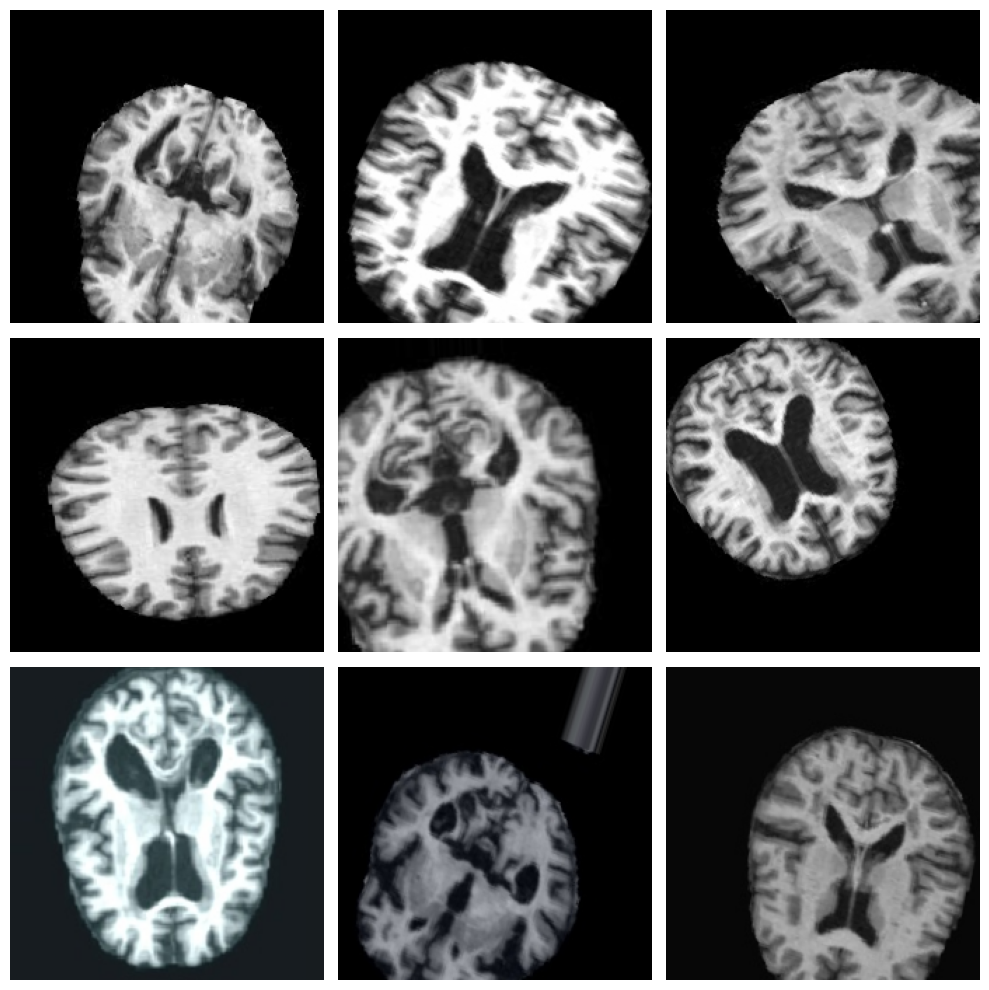

In [19]:
import matplotlib.pyplot as plt
sample_images,sample_labels=next(train_data)
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(sample_images[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [20]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
class_weights=compute_class_weight(class_weight='balanced',classes=np.unique(train_data.classes),y=train_data.classes)
class_weights_dict=dict(enumerate(class_weights))

In [21]:
print(class_weights_dict)

{0: 0.63775, 1: 0.63775, 2: 0.4982421875, 3: 0.5694196428571429, 4: 3.9367283950617282, 5: 3.8792579075425793, 6: 3.18875, 7: 3.6318337129840548}


In [22]:
from tensorflow.keras import layers,models,Model,Input
from tensorflow.keras.applications import DenseNet201
base_model=DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

I0000 00:00:1756231621.413592      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [23]:
base_model.trainable=False

In [24]:
model=models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(units=1024,activation='silu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),
    layers.Dense(units=512,activation='silu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.25),
    layers.Dense(units=256,activation='silu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.2),
    layers.Dense(units=128,activation='silu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.15),
    layers.Dense(units=64,activation='silu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.1),
    layers.Dense(units=8,activation='softmax')
])

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,967,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,994,824 (80.09 MB)

 Trainable params: 2,668,872 (10.18 MB)

 Non-trainable params: 18,325,952 (69.91 MB)

In [26]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC,TopKCategoricalAccuracy
model.compile(optimizer=Adam(learning_rate=1e-4),loss='categorical_crossentropy',metrics=['accuracy',TopKCategoricalAccuracy(k=5,name='top5'),AUC(name='auc')])

In [27]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopper=EarlyStopping(patience=5,monitor='val_loss',restore_best_weights=True)

In [28]:
history=model.fit(train_data,validation_data=val_data,epochs=30,batch_size=32,callbacks=[early_stopper],verbose=1,class_weight=class_weights_dict)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1756231682.690839     122 service.cc:148] XLA service 0x7fb370003570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756231682.691746     122 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756231687.530652     122 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/1196 ━━━━━━━━━━━━━━━━━━━━ 1:37 82ms/step - accuracy: 0.1172 - auc: 0.4977 - loss: 4.1738 - top5: 0.5938   

I0000 00:00:1756231709.385612     122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1196/1196 ━━━━━━━━━━━━━━━━━━━━ 525s 389ms/step - accuracy: 0.3433 - auc: 0.7297 - loss: 1.7052 - top5: 0.8270 - val_accuracy: 0.6449 - val_auc: 0.9384 - val_loss: 0.9445 - val_top5: 0.9812
Epoch 2/30
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 410s 343ms/step - accuracy: 0.5782 - auc: 0.9065 - loss: 0.9271 - top5: 0.9687 - val_accuracy: 0.7011 - val_auc: 0.9599 - val_loss: 0.7533 - val_top5: 0.9953
Epoch 3/30
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 415s 347ms/step - accuracy: 0.6367 - auc: 0.9412 - loss: 0.7423 - top5: 0.9905 - val_accuracy: 0.7321 - val_auc: 0.9712 - val_loss: 0.6237 - val_top5: 0.9992
Epoch 4/30
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 429s 358ms/step - accuracy: 0.6686 - auc: 0.9529 - loss: 0.6468 - top5: 0.9956 - val_accuracy: 0.7524 - val_auc: 0.9758 - val_loss: 0.5696 - val_top5: 1.0000
Epoch 5/30
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 435s 363ms/step - accuracy: 0.6788 - auc: 0.9573 - loss: 0.6016 - top5: 0.9964 - val_accuracy: 0.7526 - val_auc: 0.9729 - val_loss: 0.5943 - val_top5: 0.9992
Epoch 6/30


In [29]:
base_model.trainable=True

In [30]:
model.compile(optimizer=Adam(learning_rate=1e-5),loss='categorical_crossentropy',metrics=['accuracy',TopKCategoricalAccuracy(k=5,name='top5'),AUC(name='auc')])

In [33]:
history=model.fit(train_data,validation_data=val_data,epochs=15,batch_size=32,callbacks=[early_stopper],verbose=1,class_weight=class_weights_dict)

Epoch 1/15


2025-08-26 22:06:24.138837: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m6.291265584s

********************************
[Compiling module a_inference_one_step_on_data_1332654__.93335] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


 849/1196 ━━━━━━━━━━━━━━━━━━━━ 1:59 345ms/step - accuracy: 0.5567 - auc: 0.8927 - loss: 1.2185 - top5: 0.9720

2025-08-26 22:15:45.308129: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m4.206168729s

********************************
[Compiling module a_inference_one_step_on_data_1332654__.93335] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


1196/1196 ━━━━━━━━━━━━━━━━━━━━ 973s 608ms/step - accuracy: 0.5782 - auc: 0.9045 - loss: 1.1008 - top5: 0.9772 - val_accuracy: 0.7566 - val_auc: 0.9764 - val_loss: 0.5579 - val_top5: 0.9998
Epoch 2/15
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 420s 351ms/step - accuracy: 0.7314 - auc: 0.9693 - loss: 0.4499 - top5: 0.9989 - val_accuracy: 0.8243 - val_auc: 0.9863 - val_loss: 0.4133 - val_top5: 1.0000
Epoch 3/15
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 420s 351ms/step - accuracy: 0.7838 - auc: 0.9798 - loss: 0.3460 - top5: 0.9997 - val_accuracy: 0.8606 - val_auc: 0.9908 - val_loss: 0.3394 - val_top5: 1.0000
Epoch 4/15
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 409s 342ms/step - accuracy: 0.8209 - auc: 0.9859 - loss: 0.2756 - top5: 0.9999 - val_accuracy: 0.8915 - val_auc: 0.9941 - val_loss: 0.2815 - val_top5: 1.0000
Epoch 5/15
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 409s 342ms/step - accuracy: 0.8524 - auc: 0.9900 - loss: 0.2383 - top5: 1.0000 - val_accuracy: 0.9183 - val_auc: 0.9962 - val_loss: 0.2298 - val_top5: 1.0000
Epoch 6/15


In [34]:
test_loss,test_accuracy,test_top5,test_auc=model.evaluate(test_data,verbose=1)
print(f"\nTest Loss:{test_loss:.4f}")
print(f"Test Accuracy:{test_accuracy*100:.4f}%")
print(f"Test Top-5 Accuracy:{test_top5*100:.4f}%")
print(f"Test AUC:{test_auc*100:.4f}%")

240/240 ━━━━━━━━━━━━━━━━━━━━ 37s 155ms/step - accuracy: 0.9956 - auc: 0.9999 - loss: 0.0194 - top5: 1.0000

Test Loss:0.0355
Test Accuracy:99.1113%
Test Top-5 Accuracy:100.0000%
Test AUC:99.9575%


In [35]:
val_loss,val_accuracy,val_top5,val_auc=model.evaluate(val_data,verbose=1)
print(f"\nValidation Loss:{val_loss:.4f}")
print(f"Validation Accuracy:{val_accuracy*100:.4f}%")
print(f"Validation Top-5 Accuracy:{val_top5*100:.4f}%")
print(f"Validation AUC:{val_auc*100:.4f}%")

160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - accuracy: 0.9967 - auc: 0.9999 - loss: 0.0168 - top5: 1.0000

Validation Loss:0.0337
Validation Accuracy:99.2362%
Validation Top-5 Accuracy:100.0000%
Validation AUC:99.9580%


In [36]:
import numpy as np
y_pred=model.predict(test_data)
y_pred_class=np.argmax(y_pred,axis=1)
y_true=test_data.classes

240/240 ━━━━━━━━━━━━━━━━━━━━ 60s 168ms/step


In [37]:
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,classification_report,confusion_matrix

accuracy=accuracy_score(y_true,y_pred_class)
precision=precision_score(y_true,y_pred_class,average='weighted',zero_division=1)
recall=recall_score(y_true,y_pred_class,average='weighted')
f1=f1_score(y_true,y_pred_class,average='weighted',zero_division=1)

print("\nPerformance Metrics Breakdown:")
print(f"Accuracy:{accuracy:.4f}")
print(f"Precision:{precision:.4f}")
print(f"Recall:{recall:.4f}")
print(f"F1-Score:{f1:.4f}")


Performance Metrics Breakdown:
Accuracy:0.9911
Precision:0.9912
Recall:0.9911
F1-Score:0.9911


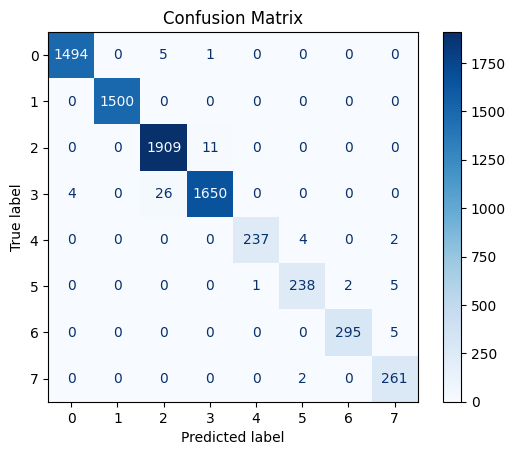

In [38]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm=confusion_matrix(y_true,y_pred_class)
disp=ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues,values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [39]:
class_labels=list(val_data.class_indices.keys())

In [40]:
print("Classification Report:")
print(classification_report(y_true,y_pred_class,target_names=class_labels,zero_division=1))

Classification Report:
                           precision    recall  f1-score   support

    Alzhimer_MildDemented       1.00      1.00      1.00      1500
Alzhimer_ModerateDemented       1.00      1.00      1.00      1500
     Alzhimer_NonDemented       0.98      0.99      0.99      1920
Alzhimer_VeryMildDemented       0.99      0.98      0.99      1680
             Tumor_glioma       1.00      0.98      0.99       243
         Tumor_meningioma       0.98      0.97      0.97       246
            Tumor_notumor       0.99      0.98      0.99       300
          Tumor_pituitary       0.96      0.99      0.97       263

                 accuracy                           0.99      7652
                macro avg       0.99      0.99      0.99      7652
             weighted avg       0.99      0.99      0.99      7652



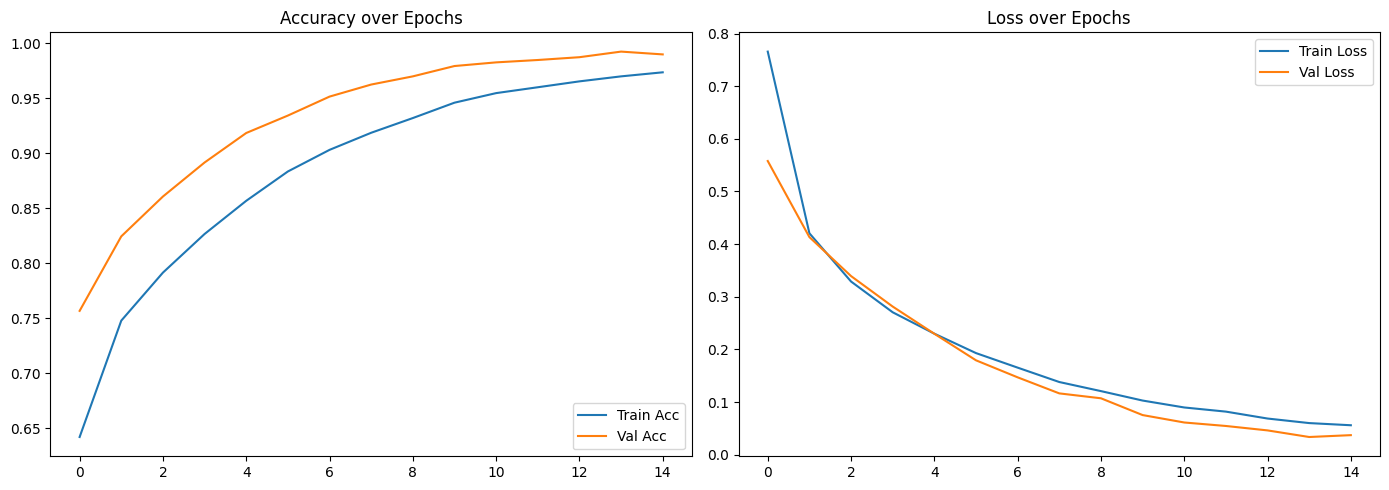

In [41]:
import matplotlib.pyplot as plt

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs_range=range(len(acc))

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Train Acc')
plt.plot(epochs_range,val_acc,label='Val Acc')
plt.legend(loc='lower right')
plt.title('Accuracy over Epochs')


plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Train Loss')
plt.plot(epochs_range,val_loss,label='Val Loss')
plt.legend(loc='upper right')
plt.title('Loss over Epochs')

plt.tight_layout()
plt.savefig("training_curves.png")
plt.show()

In [42]:
from tensorflow.keras.models import save_model
save_model(model,'DenseNET201_WEIGHTS_BIASES.h5')

In [45]:
import zipfile
import os
from IPython.display import FileLink

zip_file = 'model_weights.zip'
with zipfile.ZipFile(zip_file, 'w') as zipf:
    zipf.write('/kaggle/working/DenseNET201_WEIGHTS_BIASES.h5')
FileLink(zip_file)

/kaggle/working/model_weights.zip